# H-SAF Soil Moisture Week 2019
Exercise - Application for soil moisture data assimilation for flood prediction

In this exercise we will test the sensitivity of flood response to initial soil moisture conditions. The comparison of optimal initial soil moisture condition for the different HSAF products will be carried out by selecting two flood events occurred in the study basin.

All codes and data are freely available at [eumetrain_hsaf_github_repository](https://github.com/H-SAF/eumetrain_sm_week_2019.git).

**Metop ASCAT CDR 12.5 km sampling (2007-2017) H113**
1. sm -- soil moisture [%]
2. frozen_probability -- frozen soil probability H %]
3. snow_probability -- snow cover probability [%]
4. time -- time step [daily]

**ECMWF RZSM DataRecord 16 km resolution (1992-2014) H27**
1. var40 -- root zone soil moisture - level 1 - 0-7 cm
2. var41 -- root zone soil moisture - level 2 - 7-28 cm
3. var42 -- root zone soil moisture - level 3 - 28-100 cm
4. var43 -- root zone soil moisture - level 4 - 100-289 cm
5. time -- time step [daily]

## Libraries

In [63]:
import os
import warnings
import ascat

from MILc_2 import *

from pytesmo import temporal_matching
from pytesmo import scaling
from pytesmo.time_series.filters import exp_filter

# Info
print('Libraries loaded!')
# Filter warnings in notebook
warnings.filterwarnings("ignore")

Libraries loaded!


In [64]:
# Domain information
domain_name = 'TEVERE'
domain_area = 5720
domain_ctime = 30 # best ctime for swi generation

exercize = 'ex_data_assimilation'
file_data = 'TEVERE_DATA.txt'
file_parameters = 'TEVERE_PAR.txt'

# Path(s)
root_path='/home/fabio/Desktop/PyCharm_Workspace/fp-labs/hsaf_event_week_2019/'

data_path_dyn = os.path.join(root_path,'test_data', 'dynamic')
data_path_static = os.path.join(root_path,'test_data', 'static')

tmp_path = os.path.join(root_path, 'test_outcome', 'tmp', exercize)
img_path = os.path.join(root_path, 'test_outcome', 'img', exercize)
ancillary_path = os.path.join(root_path, 'test_outcome', 'ancillary', exercize)

milc_path_static = os.path.join(data_path_static, 'milc')
milc_path_dynamic = os.path.join(data_path_dyn, 'milc')

# Create img path
if not os.path.exists(img_path):
    os.makedirs(img_path)
# Create ancillary path
if not os.path.exists(ancillary_path):
    os.makedirs(ancillary_path)
# Create tmp path
if not os.path.exists(tmp_path):
    os.makedirs(tmp_path)

## Data
<div style="text-align: justify">In this step the ground and satellite data will be loaded into the workspace.
To run the model for the study basin, please change the "name" variable according to the basin name, replace the correct basin area ("Ab" variable) value and change the H27_best and ctime_SWI_best variables according to the values obtained in exercise 5.</div>

In [65]:
# Get data
data_input = pd.read_csv(os.path.join(milc_path_dynamic,file_data),
                   index_col=0, header = None, 
                   names = ['P','T','Q','H113','H27_L1','H27_L2','H27_L3','H27_L4'],
                   na_values='nan')

# Get parameter(s)
parameters = np.loadtxt(os.path.join(milc_path_static, file_parameters))

# Print data and parameters
print(' == Input Data ==')
print(data_input.head())
print(' == Parameter(s) == ')
print(parameters)

 == Input Data ==
                            P         T          Q       H113    H27_L1  \
2007-01-01 00:00:00  3.202349  8.140181  10.079916  46.676248  0.731786   
2007-01-02 00:00:00  7.674754  5.520864   9.934817  40.011059  0.767268   
2007-01-03 00:00:00  0.053418  1.178245   9.789718  32.062826  0.760015   
2007-01-04 00:00:00  0.877974  2.309108   9.644619  17.218505  0.500714   
2007-01-05 00:00:00  0.105998  3.835236   8.970421  21.853204  0.660676   

                       H27_L2    H27_L3    H27_L4  
2007-01-01 00:00:00  0.748055  0.679018  0.691044  
2007-01-02 00:00:00  0.754463  0.681876  0.692929  
2007-01-03 00:00:00  0.751631  0.681094  0.692376  
2007-01-04 00:00:00  0.686350  0.662666  0.680064  
2007-01-05 00:00:00  0.720025  0.672820  0.686809  
 == Parameter(s) == 
[5.33995966e-01 3.00000000e+02 4.73210978e+00 1.17845554e-01
 3.83298887e-01 1.44090289e+00 7.81913276e-01 9.38949450e+00]


In [66]:
# Get data for H27 and H113
H27_data = data_input['H27_L3'].values
SWI_data = data_input['H113'].values/100

## Open-Loop - Run
<div style="text-align: justify">In this step, the model is run over the entire analysis period in order to identify one  flood event on which test the sensitivity of flood response to different initial soil moisture conditions.</div>

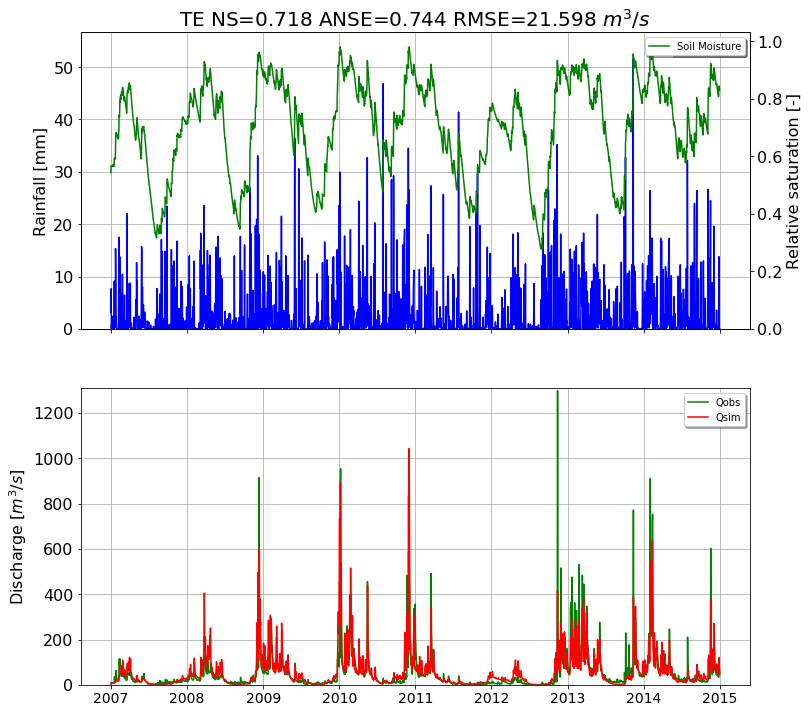

In [67]:
QobsQsim, data_model = MILC(domain_name, data_input, parameters, domain_area, 1)

<div style="text-align: justify">In this step, filtering and rescaling techniques are applied to H27 and H113 data in order to obtain soil moisture estimates to be used within the r-r model.</div>

In [68]:
jd = data_model.index.to_julian_date().get_values()
SWI_filtered = exp_filter(SWI_data, jd, ctime=domain_ctime)
SAT_scaled = scaling.mean_std(SWI_filtered, data_model['W'].values)
H27_scaled = scaling.mean_std(H27_data, data_model['W'].values)

data_workspace = pd.DataFrame(
    {"H113": data_input['H113'].values/100, "SWI": SWI_filtered, "SWI_rescaled": SAT_scaled, 
     "H27": H27_data, "H27_rescaled": H27_scaled}, index=data_model.index)

# Print data and parameters
print(' == Satellite Data == ')
print(data_workspace.head())

 == Satellite Data == 
                H113       SWI  SWI_rescaled       H27  H27_rescaled
2007-01-01  0.466762  0.466762      0.810037  0.679018      0.684505
2007-01-02  0.400111  0.432881      0.776054  0.681876      0.687360
2007-01-03  0.320628  0.394210      0.737266  0.681094      0.686579
2007-01-04  0.172185  0.335898      0.678778  0.662666      0.668174
2007-01-05  0.218532  0.310835      0.653639  0.672820      0.678315


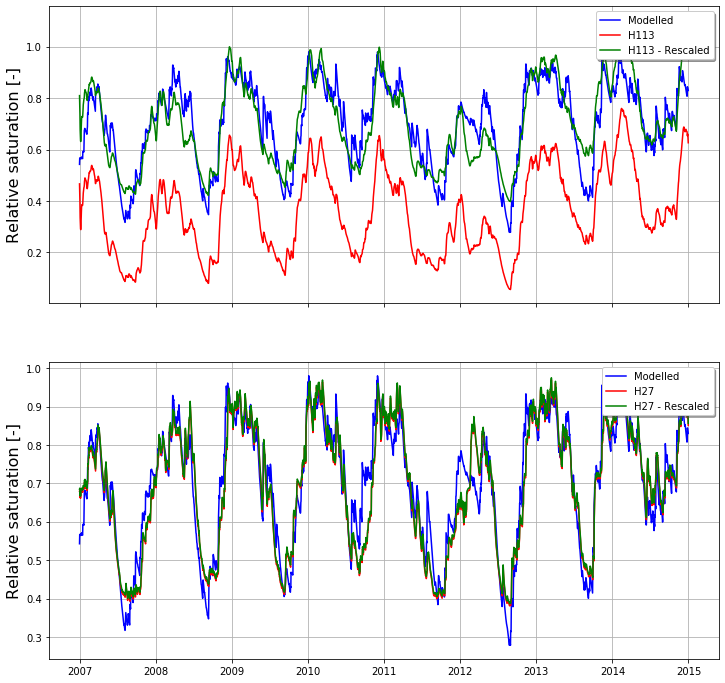

In [69]:
# Plot modelled variable(s) and observed ASCAT variable(s) 
fig, ax = plt.subplots(2, sharex=True, figsize=(12, 12))
ax[0].tick_params(axis='x', labelsize=14)
ax[0].plot(data_model.index, data_model['W'].values, label='Modelled', color='b')
ax[0].plot(data_model.index, SWI_filtered,label='H113', color='r')
ax[0].plot(data_model.index, SAT_scaled,label='H113 - Rescaled', color='g')

ax[1].plot(data_model.index, data_model['W'].values, label='Modelled', color='b')
ax[1].plot(data_model.index, H27_data,label='H27', color='r')
ax[1].plot(data_model.index, H27_scaled,label='H27 - Rescaled', color='g')

ax[0].set_ylabel('Relative saturation [-]', fontsize=16) 
ax[1].set_ylabel('Relative saturation [-]', fontsize=16) 
ax[0].grid(True)
ax[1].grid(True)
ax[0].legend(loc='upper right', shadow=True)
ax[1].legend(loc='upper right', shadow=True)

filename = os.path.join(img_path, "ex_ts_sm_comparison_h113.tiff")
fig.savefig(filename, dpi=120)

## Event 1 - Run
<div style="text-align: justify">In this step, the model is run for the first flood event identified by a start ("start_ev1" variable) and end date ("end_ev1" variable).</div>

In [70]:
# Set event times
start_ev1 = '2010-11-11'
end_ev1 = '2010-12-11'
# Other information
fig_ev1 = 1

### Event 1 - Data 
<div style="text-align: justify">To perform this analysis, select a flood event and change the "start_ev1" and "end_ev1" variables, accordingly.</div>

In [71]:
# Get event data
mask_ev1 = (data_model.index > start_ev1) & (data_model.index <= end_ev1)
data_input_ev1 = data_input.iloc[mask_ev1]

# Get parameter(s)
parameters_ev1 = np.loadtxt(os.path.join(milc_path_static, file_parameters))

### Event 1 - Simulation - Modelled SM
<div style="text-align: justify">The soil moisture conditions at the beginning of the flood event are set equal to the ones provided by the model simulation, in order to obtain a reference run</div>

 === Simulation - Modelled SM - START === 
 === Initial Soil Moisture from Model = 0.8751205159512367 === 
 === NS from Model = 0.7152862544724207 === 
 === Simulation - Modelled SM - END === 


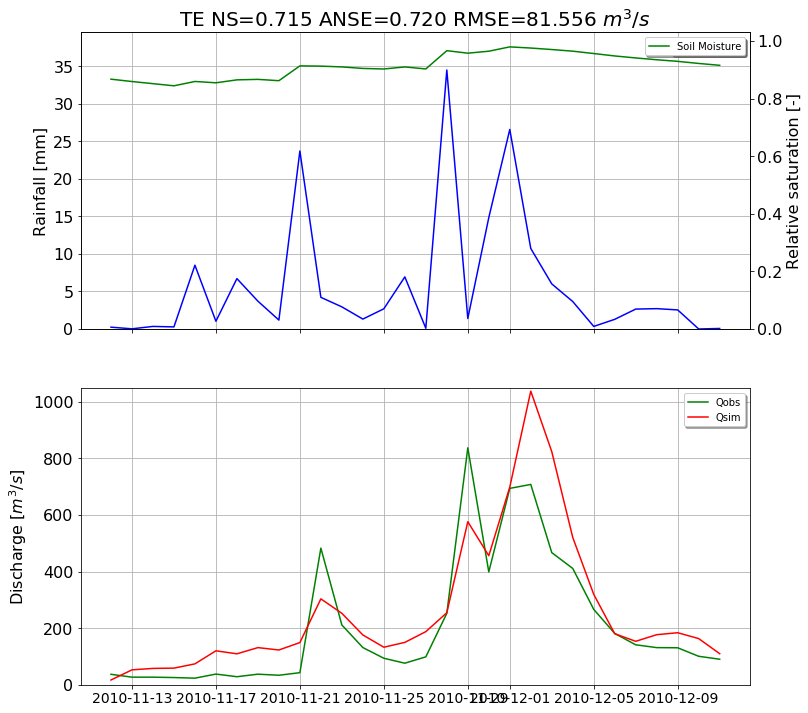

In [72]:
# Info start
print(' === Simulation - Modelled SM - START === ')
# Set initial soil moisture value
parameters_ev1[0] = data_model['W'].iloc[mask_ev1][0]
print(' === Initial Soil Moisture from Model = ' + str(parameters_ev1[0]) + ' === ')

# Run model
QobsQsim_tmp, data_model_tmp = MILC(domain_name, data_input_ev1, parameters_ev1, domain_area, fig_ev1)

# Set field(s) in dataframe for event
df_ev1 = pd.DataFrame(data_model_tmp['W'].values, index=data_model_tmp.index)
df_ev1.columns = ['W_MOD']
df_ev1 = df_ev1.join(data_model_tmp['S'])
df_ev1.rename(columns={'S':'S_MOD'},inplace=True)

# NS 
print(' === NS from Model = ' + str(QobsQsim_tmp.NS()) + ' === ')

# Info end
print(' === Simulation - Modelled SM - END === ')

### Event 1 - Simulation - H113 SM
<div style="text-align: justify">In this step, the soil moisture conditions at the beginning of the flood event are set equal to the ones provided by the original H113 estimates. Which is the impact of the changed initial soil moisture condition in terms of discharge simulation?</div>

 === Simulation - H113 SM - START === 
 === Initial Soil Moisture from H113 SM = 0.73360361 === 
 === NS from H113 SM = 0.6326281952637113 === 
 === Simulation - H113 SM - END === 


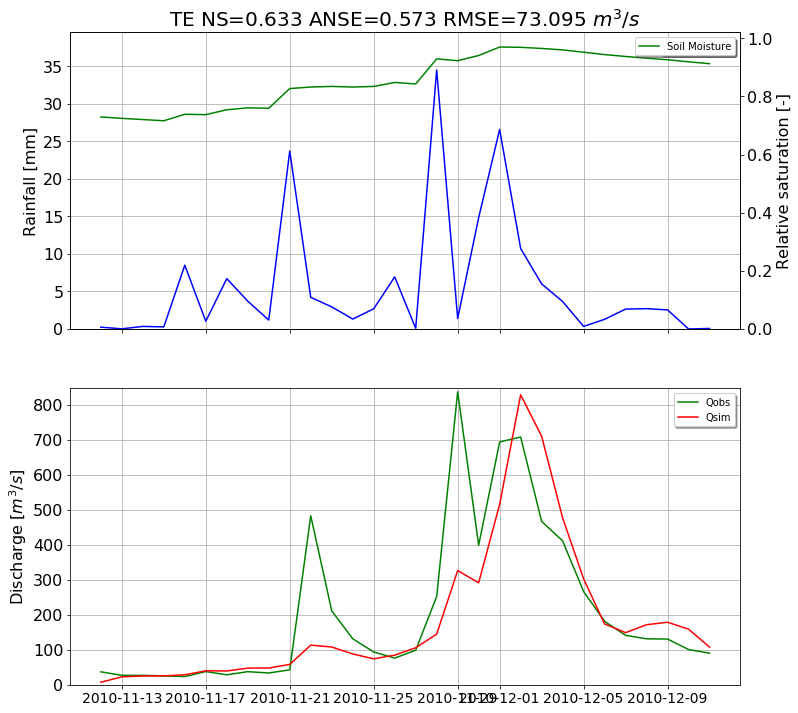

In [73]:
# Info start
print(' === Simulation - H113 SM - START === ')
# Set initial soil moisture value
parameters_ev1[0] = data_workspace.iloc[mask_ev1]['H113'][0]
print(' === Initial Soil Moisture from H113 SM = ' + str(parameters_ev1[0]) + ' === ')

# Run model 
QobsQsim_tmp, data_model_tmp = MILC(domain_name, data_input_ev1, parameters_ev1, domain_area, fig_ev1)

# Set field(s) in dataframe for event
df_ev1 = df_ev1.join(data_model_tmp['W'])
df_ev1.rename(columns = {'W':'W_H113'},inplace=True)
df_ev1 = df_ev1.join(data_model_tmp['S'])
df_ev1.rename(columns={'S':'S_H113'},inplace=True)

# NS
print(' === NS from H113 SM = ' + str(QobsQsim_tmp.NS()) + ' === ')

# Info start
print(' === Simulation - H113 SM - END === ')

### Event 1 - Simulation - H113 SWI
<div style="text-align: justify">In this step, the soil moisture conditions at the beginning of the flood event are set equal to the ones provided by the H113 SWI estimates. Which is the impact of the changed initial soil moisture condition in terms of discharge simulation?</div>

 === Simulation - H113 SWI - START === 
 === Initial Soil Moisture from H113 SWI = 0.4259260297805447 === 
 === NS from H113 SWI = -0.32709013070730997 === 
 === Simulation - H113 SWI - END === 


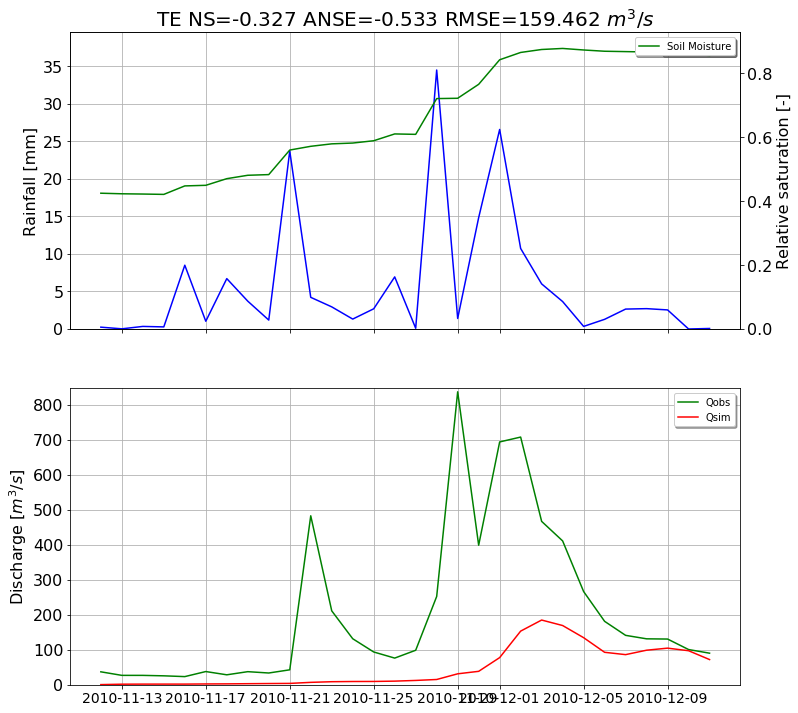

In [74]:
# Info start
print(' === Simulation - H113 SWI - START === ')
# Set initial soil moisture value
parameters_ev1[0] = data_workspace.iloc[mask_ev1]['SWI'][0]
print(' === Initial Soil Moisture from H113 SWI = ' + str(parameters_ev1[0]) + ' === ')

# Run model 
QobsQsim_tmp, data_model_tmp = MILC(domain_name, data_input_ev1, parameters_ev1, domain_area, fig_ev1)

# Set field(s) in dataframe for event
df_ev1 = df_ev1.join(data_model_tmp['W'])
df_ev1.rename(columns={'W':'W_SWI'},inplace=True)
df_ev1 = df_ev1.join(data_model_tmp['S'])
df_ev1.rename(columns={'S':'S_SWI'},inplace=True)

# NS
print(' === NS from H113 SWI = ' + str(QobsQsim_tmp.NS()) + ' === ')

# Info start
print(' === Simulation - H113 SWI - END === ')

### Event 1 - Simulation - H113 SWI Rescaled
<div style="text-align: justify">In this step, the soil moisture conditions at the beginning of the flood event are set equal to the ones provided by the SWI rescaled estimates. Which is the impact of the changed initial soil moisture condition in terms of discharge simulation?</div>

 === Simulation - H113 SWI Rescaled - START === 
 === Initial Soil Moisture from H113 SWI Rescaled = 0.769077697189562 === 
 === NS from H113 SWI Rescaled = 0.6808421409020862 === 
 === Simulation - H113 SWI Rescaled - END === 


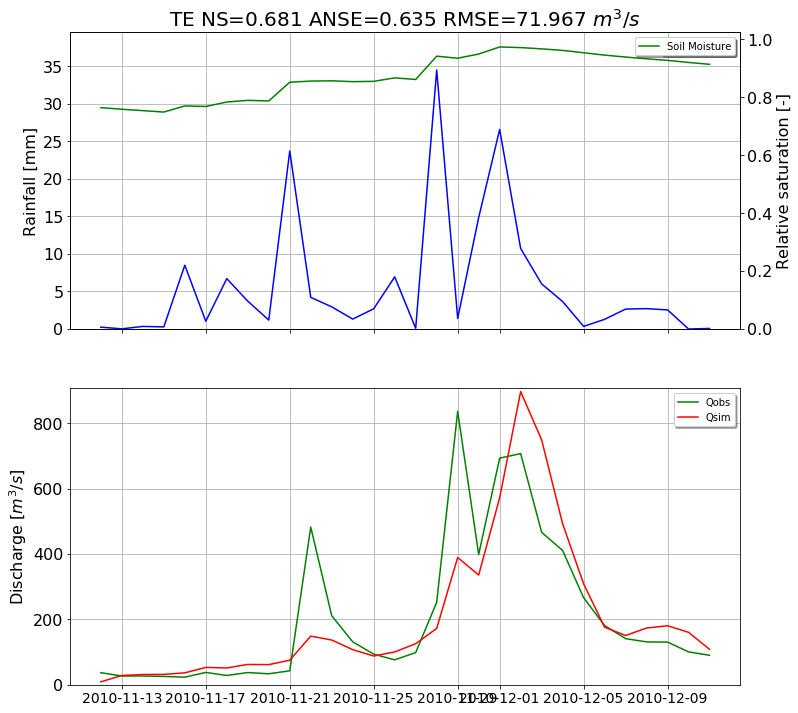

In [75]:
# Info start
print(' === Simulation - H113 SWI Rescaled - START === ')
# Set initial soil moisture value
parameters_ev1[0] = data_workspace.iloc[mask_ev1]['SWI_rescaled'][0]
print(' === Initial Soil Moisture from H113 SWI Rescaled = ' + str(parameters_ev1[0]) + ' === ')

# Run model
QobsQsim_tmp, data_model_tmp = MILC(domain_name, data_input_ev1, parameters_ev1, domain_area, fig_ev1)

# Set field(s) in dataframe for event
df_ev1 = df_ev1.join(data_model_tmp['W'])
df_ev1.rename(columns={'W':'W_SWI_rescaled'},inplace=True)
df_ev1 = df_ev1.join(data_model_tmp['S'])
df_ev1.rename(columns={'S':'S_SWI_rescaled'},inplace=True)

# NS
print(' === NS from H113 SWI Rescaled = ' + str(QobsQsim_tmp.NS()) + ' === ')

# Info end
print(' === Simulation - H113 SWI Rescaled - END === ')

### Event 1 - Simulation - H27 RZSM
<div style="text-align: justify">In this step, the soil moisture conditions at the beginning of the flood event are set equal to the ones provided by the original H27 estimates. Which is the impact of the changed initial soil moisture condition in terms of discharge simulation?</div>

 === Simulation - H27 - START === 
 === Initial Soil Moisture from H27 = 0.7574489999999999 === 
 === NS from H27 = 0.6669837415049045 === 
 === Simulation - H27 - END === 


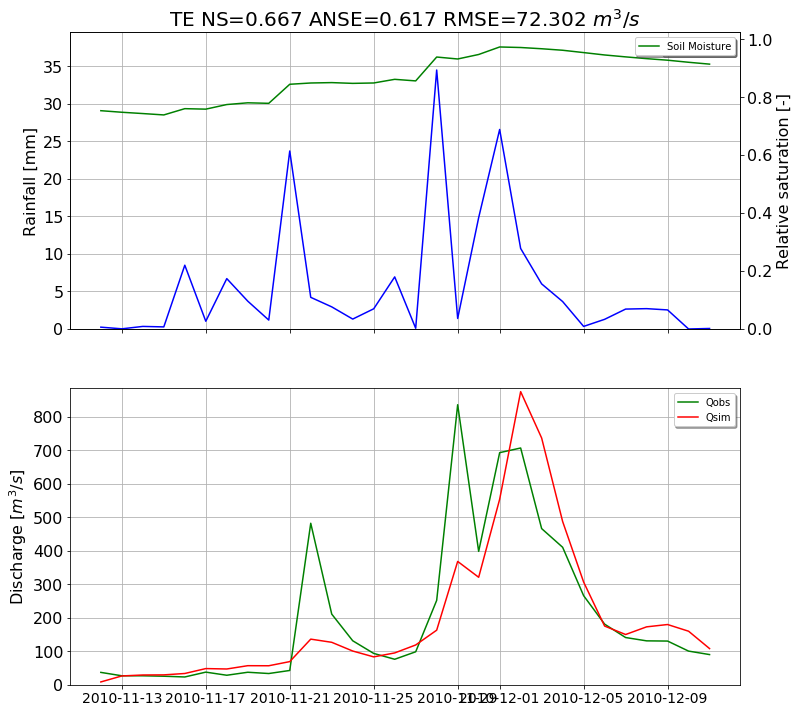

In [76]:
# Info start
print(' === Simulation - H27 - START === ')
# Set initial soil moisture value
parameters_ev1[0] = data_workspace.iloc[mask_ev1]['H27'][0]
print(' === Initial Soil Moisture from H27 = ' + str(parameters_ev1[0]) + ' === ')

# Run model
QobsQsim_tmp, data_model_tmp = MILC(domain_name, data_input_ev1, parameters_ev1, domain_area, fig_ev1)

# Set field(s) in dataframe for event
df_ev1 = df_ev1.join(data_model_tmp['W'])
df_ev1.rename(columns={'W':'W_H27'},inplace=True)
df_ev1 = df_ev1.join(data_model_tmp['S'])
df_ev1.rename(columns={'S':'S_H27'},inplace=True)

# NS
print(' === NS from H27 = ' + str(QobsQsim_tmp.NS()) + ' === ')

# Info end
print(' === Simulation - H27 - END === ')

### Event 1 - Simulation - H27 RZSM Rescaled
<div style="text-align: justify">In this step, the soil moisture conditions at the beginning of the flood event are set equal to the ones provided by the H27 rescaled estimates. Which is the impact of the changed initial soil moisture condition in terms of discharge simulation?.</div>

 === Simulation - H27 Rescaled - START === 
 === Initial Soil Moisture from H27 Rescaled = 0.7628379506222583 === 
 === NS from H27 Rescaled = 0.6736420961048708 === 
 === Simulation - H27 Rescaled - END === 


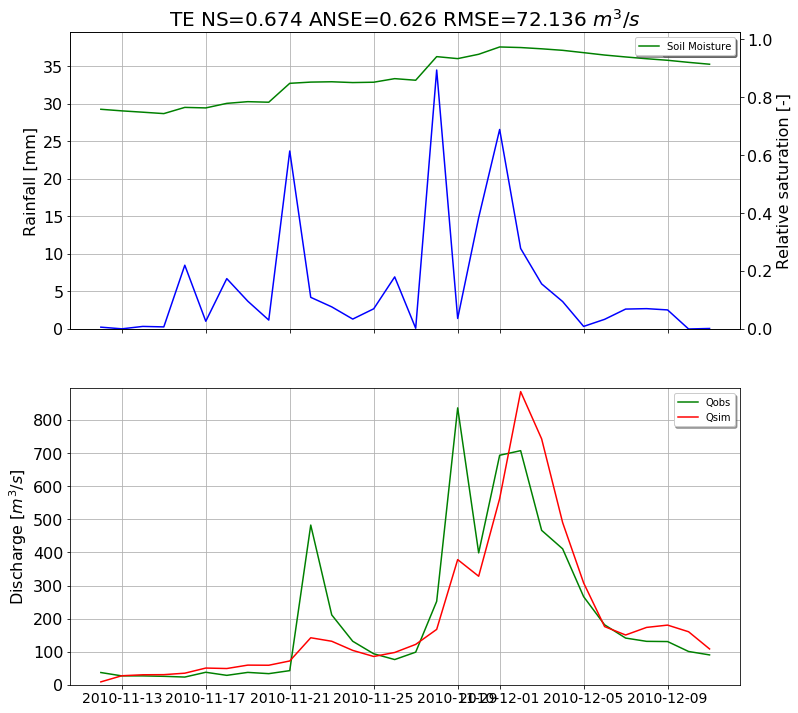

In [77]:
# Info start
print(' === Simulation - H27 Rescaled - START === ')
# Set initial soil moisture value
parameters_ev1[0] = data_workspace.iloc[mask_ev1]['H27_rescaled'][0]
print(' === Initial Soil Moisture from H27 Rescaled = ' + str(parameters_ev1[0]) + ' === ')

# Run model
QobsQsim_tmp, data_model_tmp = MILC(domain_name, data_input_ev1, parameters_ev1, domain_area, fig_ev1)

# Set field(s) in dataframe for event
df_ev1 = df_ev1.join(data_model_tmp['W'])
df_ev1.rename(columns={'W':'W_H27_rescaled'},inplace=True)
df_ev1 = df_ev1.join(data_model_tmp['S'])
df_ev1.rename(columns={'S':'S_H27_rescaled'},inplace=True)

# NS
print(' === NS from H27 Rescaled = ' + str(QobsQsim_tmp.NS()) + ' === ')

# Info end
print(' === Simulation - H27 Rescaled - END === ')

### Event 1 - Plot(s)
<div style="text-align: justify">After the different model runs, identify the soil moisture initial condition that provided the best NS value.</div>

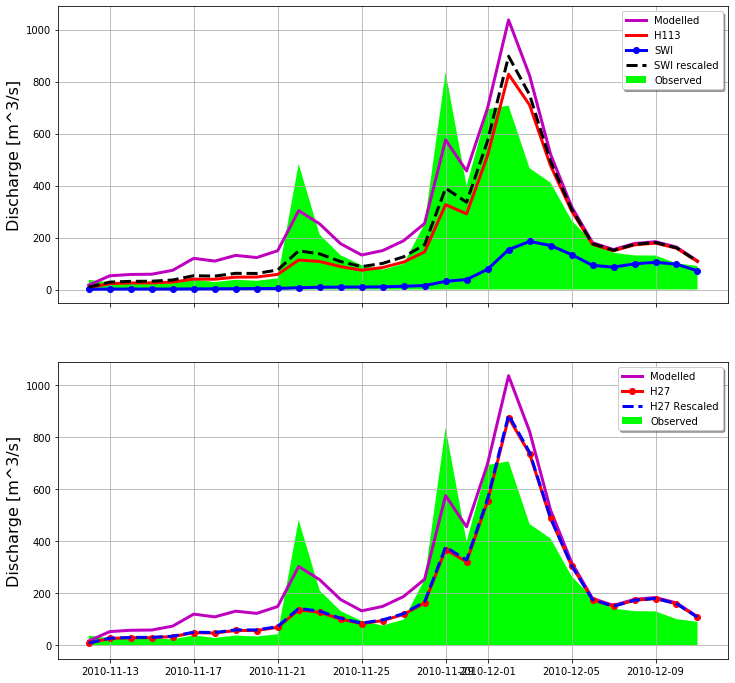

In [78]:
fig, ax = plt.subplots(2, sharex=True, figsize=(12, 12))
ax[0].tick_params(axis='x', labelsize=14)
ax[0].fill_between(data_input_ev1.index, data_input_ev1['Q'].values, label='Observed', facecolor=(0, 1, 0))
ax[0].plot(df_ev1.index, df_ev1['S_MOD'].values, label='Modelled', color='m', linewidth=3.0)
ax[0].plot(df_ev1.index, df_ev1['S_H113'].values, label='H113', color='r', linewidth=3.0)
ax[0].plot(df_ev1.index, df_ev1['S_SWI'].values,'r-o', label='SWI', color='b', linewidth=3.0)
ax[0].plot(df_ev1.index, df_ev1['S_SWI_rescaled'].values,'r--', label='SWI rescaled', color='k', linewidth=3.0)

ax[1].fill_between(data_input_ev1.index, data_input_ev1['Q'].values, label='Observed', facecolor=(0, 1, 0))
ax[1].plot(df_ev1.index, df_ev1['S_MOD'].values, label='Modelled', color='m', linewidth=3.0)
ax[1].plot(df_ev1.index, df_ev1['S_H27'].values,'r-o', label='H27', color='r', linewidth=3.0)
ax[1].plot(df_ev1.index, df_ev1['S_H27_rescaled'].values, 'r--', label='H27 Rescaled', color='b', linewidth=3.0)

ax[0].set_ylabel('Discharge [m^3/s]', fontsize=16) 
ax[1].set_ylabel('Discharge [m^3/s]', fontsize=16) 
ax[0].grid(True)
ax[1].grid(True)
ax[0].legend(loc='upper right', shadow=True)
ax[1].legend(loc='upper right', shadow=True)

filename = os.path.join(img_path, "ex_ts_discharge_sm_ev1.tiff")
fig.savefig(filename, dpi=120)

## Event 2 - Run
<div style="text-align: justify">In this step, the model is run for the second flood event identified by a start ("start_ev2" variable) and end date ("end_ev2" variable). The soil moisture conditions at the beginning of the flood event are set equal to the ones provided by the model simulation, in order to obtain a reference run. To perform this analysis, select a flood event and change the "start_ev1" and "end_ev1" variables, accordingly.</div>

In [79]:
# Set event times
start_ev2 = '2009-12-27'
end_ev2 = '2010-01-17'
# Other information
fig_ev2 = 0

### Event 2 - Data 


In [80]:
# Get event data
mask_ev2 = (data_model.index > start_ev2) & (data_model.index <= end_ev2)
data_input_ev2 = data_input.iloc[mask_ev2]

# Get parameter(s)
parameters_ev2 = np.loadtxt(os.path.join(milc_path_static, file_parameters))

### Event 2 - Simulation - Modelled SM

In [81]:
# Info start
print(' === Simulation - Modelled SM - START === ')
# Set initial soil moisture value
parameters_ev2[0] = data_model['W'].iloc[mask_ev2][0]
print(' === Initial Soil Moisture from Model = ' + str(parameters_ev2[0]) + ' === ')

# Run model
QobsQsim_tmp, data_model_tmp = MILC(domain_name, data_input_ev2, parameters_ev2, domain_area, fig_ev2)

# Set field(s) in dataframe for event
df_ev2 = pd.DataFrame(data_model_tmp['W'].values, index=data_model_tmp.index)
df_ev2.columns = ['W_MOD']
df_ev2 = df_ev2.join(data_model_tmp['S'])
df_ev2.rename(columns={'S':'S_MOD'},inplace=True)

# NS 
print(' === NS from Model = ' + str(QobsQsim_tmp.NS()) + ' === ')

# Info start
print(' === Simulation - Modelled SM - END === ')

 === Simulation - Modelled SM - START === 
 === Initial Soil Moisture from Model = 0.9188554535343101 === 
 === NS from Model = 0.4500202865856213 === 
 === Simulation - Modelled SM - END === 


### Event 2 - Simulation - H113 SM

In [82]:
# Info start
print(' === Simulation - H113 SM - START === ')
# Set initial soil moisture value
parameters_ev2[0] = data_workspace.iloc[mask_ev2]['H113'][0]
print(' === Initial Soil Moisture from H113 SM = ' + str(parameters_ev2[0]) + ' === ')

# Run model
QobsQsim_tmp, data_model_tmp = MILC(domain_name, data_input_ev2, parameters_ev2, domain_area, fig_ev2)

# Set field(s) in dataframe for event
df_ev2 = df_ev2.join(data_model_tmp['W'])
df_ev2.rename(columns = {'W':'W_H113'},inplace=True)
df_ev2 = df_ev2.join(data_model_tmp['S'])
df_ev2.rename(columns={'S':'S_H113'},inplace=True)

# NS 
print(' === NS from H113 SM = ' + str(QobsQsim_tmp.NS()) + ' === ')

# Info end
print(' === Simulation - H113 SM - END === ')

 === Simulation - H113 SM - START === 
 === Initial Soil Moisture from H113 SM = 0.69950366 === 
 === NS from H113 SM = 0.5283324022846521 === 
 === Simulation - H113 SM - END === 


### Event 2 - Simulation - H113 SWI

In [83]:
# Info start
print(' === Simulation - H113 SWI - START === ')
# Set initial soil moisture value
parameters_ev2[0] = data_workspace.iloc[mask_ev2]['SWI'][0]
print(' === Initial Soil Moisture from H113 SWI = ' + str(parameters_ev2[0]) + ' === ')

# Run model
QobsQsim_tmp, data_model_tmp = MILC(domain_name, data_input_ev2, parameters_ev2, domain_area, fig_ev2)

# Set field(s) in dataframe for event
df_ev2 = df_ev2.join(data_model_tmp['W'])
df_ev2.rename(columns = {'W':'W_SWI'},inplace=True)
df_ev2 = df_ev2.join(data_model_tmp['S'])
df_ev2.rename(columns={'S':'S_SWI'},inplace=True)

# NS 
print(' === NS from H113 SWI = ' + str(QobsQsim_tmp.NS()) + ' === ')

# Info end
print(' === Simulation - H113 SWI - END === ')

 === Simulation - H113 SWI - START === 
 === Initial Soil Moisture from H113 SWI = 0.5245542233847812 === 
 === NS from H113 SWI = -0.3645976421569348 === 
 === Simulation - H113 SWI - END === 


### Event 2 - Simulation - H113 SWI Rescaled

In [84]:
# Info start
print(' === Simulation - H113 SWI Rescaled - START === ')
# Set initial soil moisture value
parameters_ev2[0] = data_workspace.iloc[mask_ev2]['SWI'][0]
print(' === Initial Soil Moisture from H113 SWI Rescaled = ' + str(parameters_ev2[0]) + ' === ')

# Run model
QobsQsim_tmp, data_model_tmp = MILC(domain_name, data_input_ev2, parameters_ev2, domain_area, fig_ev2)

# Set field(s) in dataframe for event
df_ev2 = df_ev2.join(data_model_tmp['W'])
df_ev2.rename(columns = {'W':'W_SWI_rescaled'},inplace=True)
df_ev2 = df_ev2.join(data_model_tmp['S'])
df_ev2.rename(columns={'S':'S_SWI_rescaled'},inplace=True)

# NS 
print(' === NS from H113 SWI Rescaled = ' + str(QobsQsim_tmp.NS()) + ' === ')

# Info end
print(' === Simulation - H113 SWI Rescaled - END === ')

 === Simulation - H113 SWI Rescaled - START === 
 === Initial Soil Moisture from H113 SWI Rescaled = 0.5245542233847812 === 
 === NS from H113 SWI Rescaled = -0.3645976421569348 === 
 === Simulation - H113 SWI Rescaled - END === 


### Event 2 - Simulation - H27

In [85]:
# Info start
print(' === Simulation - H27 - START === ')
# Set initial soil moisture value
parameters_ev2[0] = data_workspace.iloc[mask_ev2]['H27'][0]
print(' === Initial Soil Moisture from H27 = ' + str(parameters_ev2[0]) + ' === ')

# Run model
QobsQsim_tmp, data_model_tmp = MILC(domain_name, data_input_ev2, parameters_ev2, domain_area, fig_ev2)

# Set field(s) in dataframe for event
df_ev2 = df_ev2.join(data_model_tmp['W'])
df_ev2.rename(columns = {'W':'W_H27'},inplace=True)
df_ev2 = df_ev2.join(data_model_tmp['S'])
df_ev2.rename(columns={'S':'S_H27'},inplace=True)

# NS 
print(' === NS from H27 = ' + str(QobsQsim_tmp.NS()) + ' === ')

# Info end
print(' === Simulation - H27 - END === ')

 === Simulation - H27 - START === 
 === Initial Soil Moisture from H27 = 0.887417 === 
 === NS from H27 = 0.6240585688701732 === 
 === Simulation - H27 - END === 


### Event 2 - Simulation - H27 Rescaled

In [86]:
# Info start
print(' === Simulation - H27 Rescaled - START === ')
# Set initial soil moisture value
parameters_ev2[0] = data_workspace.iloc[mask_ev2]['H27_rescaled'][0]
print(' === Initial Soil Moisture from H27 Rescaled = ' + str(parameters_ev2[0]) + ' === ')

# Run model
QobsQsim_tmp, data_model_tmp = MILC(domain_name, data_input_ev2, parameters_ev2, domain_area, fig_ev2)

# Set field(s) in dataframe for event
df_ev2 = df_ev2.join(data_model_tmp['W'])
df_ev2.rename(columns = {'W':'W_H27_rescaled'},inplace=True)
df_ev2 = df_ev2.join(data_model_tmp['S'])
df_ev2.rename(columns={'S':'S_H27_rescaled'},inplace=True)

# NS 
print(' === NS from H27 Rescaled = ' + str(QobsQsim_tmp.NS()) + ' === ')

# Info end
print(' === Simulation - H27 Rescaled - END === ')

 === Simulation - H27 Rescaled - START === 
 === Initial Soil Moisture from H27 Rescaled = 0.8926429719738647 === 
 === NS from H27 Rescaled = 0.5995250293669758 === 
 === Simulation - H27 Rescaled - END === 


### Event 2 - Plot(s)
<div style="text-align: justify">After the different model runs, identify the soil moisture initial condition that provided the best NS value.</div>

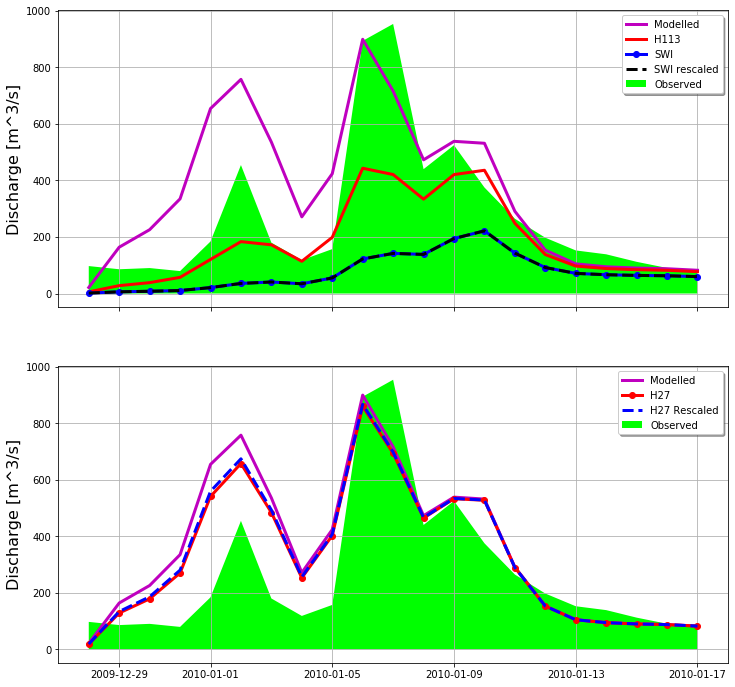

In [87]:
fig, ax = plt.subplots(2, sharex=True, figsize=(12, 12))
ax[0].tick_params(axis='x', labelsize=14)
ax[0].fill_between(data_input_ev2.index, data_input_ev2['Q'].values, label='Observed', facecolor=(0, 1, 0))
ax[0].plot(df_ev2.index, df_ev2['S_MOD'].values, label='Modelled', color='m', linewidth=3.0)
ax[0].plot(df_ev2.index, df_ev2['S_H113'].values, label='H113', color='r', linewidth=3.0)
ax[0].plot(df_ev2.index, df_ev2['S_SWI'].values,'r-o', label='SWI', color='b', linewidth=3.0)
ax[0].plot(df_ev2.index, df_ev2['S_SWI_rescaled'].values,'r--', label='SWI rescaled', color='k', linewidth=3.0)

ax[1].fill_between(data_input_ev2.index, data_input_ev2['Q'].values, label='Observed', facecolor=(0, 1, 0))
ax[1].plot(df_ev2.index, df_ev2['S_MOD'].values, label='Modelled', color='m', linewidth=3.0)
ax[1].plot(df_ev2.index, df_ev2['S_H27'].values,'r-o', label='H27', color='r', linewidth=3.0)
ax[1].plot(df_ev2.index, df_ev2['S_H27_rescaled'].values, 'r--', label='H27 Rescaled', color='b', linewidth=3.0)

ax[0].set_ylabel('Discharge [m^3/s]', fontsize=16) 
ax[1].set_ylabel('Discharge [m^3/s]', fontsize=16) 
ax[0].grid(True)
ax[1].grid(True)
ax[0].legend(loc='upper right', shadow=True)
ax[1].legend(loc='upper right', shadow=True)

filename = os.path.join(img_path, "ex_ts_discharge_sm_ev2.tiff")
fig.savefig(filename, dpi=120)

#### On-the-job Training:
* Define a new event using a different time_start and time_end
* Define a new event using a different domain
* Evaluate the flood response changing the initial soil moisture conditions
* Visualization and comparison of soil moisture and discharges time series 
* Investigate the sensitivity of flood response to initial soil moisture conditions
* Summarize the obtained results in terms of initial soil moisture conditions and NS